In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg19, VGG19_Weights
from torchvision.io import decode_image
from torchvision.transforms import transforms
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
print("Current device --->", device)

Current device ---> cuda


*Pre-trained VGG-19*

In [158]:
# model instance
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [159]:
total_parameters = 0
for name, params in cnn.named_parameters():
  # print(name, params.nelement())
  total_parameters += params.nelement()

print(" ")
print("Total parameters:", total_parameters)

 
Total parameters: 20024384


*A. Images are imported and then image preprocessing steps are done*

In [160]:
img_size = 512 if torch.cuda.is_available() else 128  # size of the image when sending to our model

# image preprocessig
loader = transforms.Compose([
    transforms.Resize(img_size),  # img resize
    transforms.ToTensor(),        # convert to tensor (as a default it normalize pixel to between 0-1 by dividing by 255)
])


def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)    # adding extra dim for fitting correctly in our model
  return image.to(device, torch.float)

content_image = image_loader("/content/slim shady.jpg")
style_image = image_loader("/content/paint_square.jpg")

assert content_image.size() == style_image.size(), "make sure content image and style image are same size"

*B. Converting normalized image to it's original pixel form*

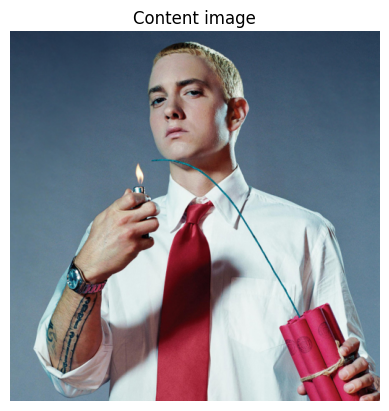

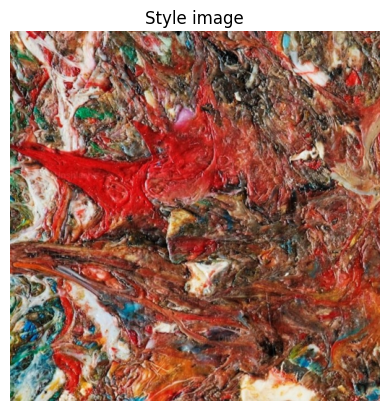

In [161]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
  image = tensor.cpu().clone()    # don't change original tensor
  image = image.squeeze(0)      # remove that fake dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

plt.figure()
plt.axis('off')
imshow(content_image, 'Content image')

plt.figure()
plt.axis("off")
imshow(style_image, "Style image")

*C. Loss Functions : Content Loss and Style Loss*

In [162]:
class ContentLoss(nn.Module):

  def __init__(self, target):
    super(ContentLoss, self).__init__()

    self.target = target.detach()   # we don't computation graph

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

# takes and feature maps then computes gram matrix (unnormalized co-variance matrix for finding similarity between feature maps)
def gram_matrix(input):
  b, c, h, w = input.size()          # batch_size, channels, height, width
  features = input.view(b * c, h * w)
  G = torch.mm(features, features.t())

  return G.div(b*c*h*w)

class StyleLoss(nn.Module):

  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

*D. Image Normalization (How it done in VGG official network)*

In [163]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):

  def __init__(self, mean, std):
    super(Normalization, self).__init__()

    self.mean = mean.view(-1, 1, 1)   # shape of [C, 1, 1]
    self.std = std.view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std


*E. Neural Style Transfer Architecture Implementation*

In [164]:
# these are only layer that we are going to for content/style extraction and also for losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean,
                               normalization_std, style_img, content_img,
                               content_layers =  content_layers_default,
                               style_layers = style_layers_default):

  normalization = Normalization(normalization_mean, normalization_std)

  # just storeing our losses in list so we can later iter over
  content_losses = []
  style_losses = []

  # just recreate our own network only with needed layers
  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = "conv_{}".format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      # in original network they use inplace relu activation true but that's won't work well in neural style
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    else:
      raise RuntimeError("Unrecognized Layer {}".format(layer.___class__.__name___))

    model.add_module(name, layer)

    # add content loss
    if name in content_layers:
      target = model(content_img).detach()    # we don't our model parameters to update
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)

    # add sytle loss
    if name in style_layers:
      target_features = model(style_img).detach()
      style_loss = StyleLoss(target_features)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # trim out layers that not need for our implementation (means after layer 5)
  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:(i+1)]
  return model, content_losses, style_losses


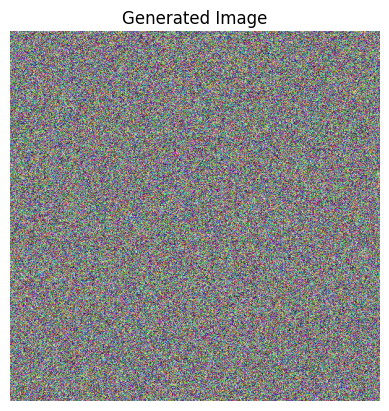

In [165]:
# Generated artistic image right now 😂
input_image= torch.randn(content_image.data.size())
plt.figure()
plt.axis('off')
imshow(input_image, "Generated Image")

*F. Set out input image in learnable state*

In [166]:
def get_input_optimizer(input_image):
  # optimizer = optim.Adam([input_image], lr=1e-3, weight_decay=1e-4)
  optimizer = optim.LBFGS([input_image])
  return optimizer

*G. Finnaly Performing Neural Style Transfer*

In [167]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, epochs= 600,
                       style_weight = 1000000, content_weight=1):

  print("Building style transfer model ...")
  model, content_losses, style_losses = get_style_model_and_losses(cnn, normalization_mean,
                                                                   normalization_std, style_img, content_image)

  # set our input image in learnable mode
  input_img.requires_grad_(True)
  # set our model in eval model
  model.eval()
  model.requires_grad_(False)

  print("Optimizing ....")
  optimizer = get_input_optimizer(input_img)

  run = [0]
  while run[0] <= epochs:

    def closure():
      with torch.no_grad():
        input_img.clamp_(0, 1)

      optimizer.zero_grad()
      #forward pass
      model(input_img)
      # compute loss
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      # backward pass
      loss.backward()

      run[0] += 1
      if run[0] % 100 == 0:
        print("Epoch {}".format(run[0]))
        print(f"Style Loss: {style_score.item()} Content Loss: {content_score.item()}")

      return style_score + content_score

    # update parameters
    optimizer.step(closure)

  with torch.no_grad():
    input_img.clamp_(0, 1)

  return input_img

Building style transfer model ...
Optimizing ....
Epoch 100
Style Loss: 27.130537033081055 Content Loss: 39.482574462890625
Epoch 200
Style Loss: 5.15152645111084 Content Loss: 30.49896240234375
Epoch 300
Style Loss: 3.7459235191345215 Content Loss: 25.35140609741211
Epoch 400
Style Loss: 2.3582239151000977 Content Loss: 22.556499481201172
Epoch 500
Style Loss: 1.9386159181594849 Content Loss: 20.6572208404541
Epoch 600
Style Loss: 2.940187692642212 Content Loss: 19.211444854736328


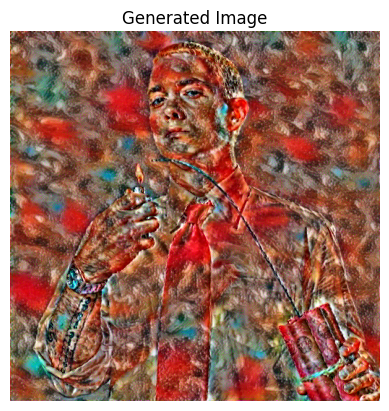

In [168]:
generated_image = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                     content_image, style_image, input_image)

plt.figure()
plt.axis('off')
imshow(generated_image, 'Generated Image')

plt.ioff()
plt.show()

In [ ]:
# this image is generated after 1000 epochs